# **Simulación de Super Manzanas**

Simulación de super manzanas como modelo de urbanismo con sistema multiagentes. Este notebook fue creado para trabajar como servidor y poder correr las simulaciones. Es necesario seguir los pasos del repositorio para poder ejecutarlo con éxito. 

**Autores:**
- Juan Carlos Garfias Tovar
- Jesús Rodriguez Tristan
- Adrián González Saldívar
- Ricardo Andres Arriaga Quezada

Proyecto creado para la clase de multiagentes del Tecnológico de Monterrey para la carrera de Tecnologias computacionales (Agosto - Diciembre 2021)

**En caso de ser usado en otro contexto favor de dar creditos y citar el repositorio**

In [1]:
# Model design
import agentpy as ap

# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import IPython
import pandas as pd

import random

# **Funciones auxiliares**


In [2]:
#remover tuplas vacias
def Remove(tuples):
    tuples = [t for t in tuples if t]
    return tuples

#delete tuples where first element is equal or minor to input
def deleteLeft(tuples, value):
    tuples = [t for t in tuples if t[1] >= value]
    return tuples

def deleteRight(tuples, value):
    tuples = [t for t in tuples if t[1] <= value]
    return tuples

def deleteUp(tuples, value):
    tuples = [t for t in tuples if t[0] >= value]
    return tuples

def deleteDown(tuples, value):
    tuples = [t for t in tuples if t[0] <= value]
    return tuples

In [3]:
#Donde se almacenan los datos de posicion de cada agente
resultsCars = []
resultsBicicles = []
resultsBuses = []
stoppedVehiclesPerStep = []
stoppedVehiclesCoordinatesX = []
stoppedVehiclesCoordinatesY = []

# **Funcion para generar los caminos**

In [4]:
roads = []

rangos = [(0,32),(35,67),(70,102),(105,137),(140,172)] #rangos de posiciones de las calles

roads = []
rows = 173 #se le aumenta uno para evitar out of range
cols = 173
for r in range(0, rows):
  roads.append([False for c in range(0, cols)])



lista = [33,34,68,69,103,104,138,139]
for y in lista:
  for x in range(173):
    roads[y][x] = True

for y in range(173):
  for x in lista:
    roads[y][x] = True

In [5]:
print(len(roads))
#print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in roads]))

173


In [6]:
coordenadas_validas = []
coordenadas_validas_buses = []
coordenadas_validas_bicicles = []

for i in range(0, rows):
  for j in range(0, cols):
    if roads[i][j] == True:
      coordenadas_validas.append((i,j))

def outterStrValidate(x,y):
      if(x > 34 and x < 138):
          if(y > 34 and y < 138):
              return False
      return True

for i in range(0, rows):
  for j in range(0, cols):
    if roads[i][j] == True:
      if outterStrValidate(i,j) and (i >= 33 and i <= 139) and (j >= 33 and j <= 139):
          coordenadas_validas_buses.append((i,j))

for i in range(0, rows):
  for j in range(0, cols):
    if roads[i][j] == True:
      if outterStrValidate(i,j) == False:
          coordenadas_validas_bicicles.append((i,j))    

# **Definicion de modelos de agentes**

In [7]:
class Car(ap.Agent):
    
    def setup(self):
        self.grid = self.model.grid
        self.random = self.model.random
        self.orientation = self.random.randint(0, 3) #0 = up, 1 = right, 2 = down, 3 = left
        self.speed = 0
        self.moving = 0 # 0: none, 1: moving, 2: stopped
        self.currentPosition = ()
        self.nextMove = ""
        self.outer = True
        #self.luck = self.random.randint(0,100) #determines who will turn first

    def nearbyCars(self):
        neighbours = self.grid.neighbors(self, distance=6)
        neighbours = neighbours.to_list()
        
        neighbours = Remove(neighbours.currentPosition) #regresa los vecinos de la posicion actual con distancia de 6

        neighbours = sorted(neighbours, key=lambda tup: tup[0])

        return neighbours
    
    def possibleRight(self):
        #check if neighbor is not at the right of the car
        traffic = self.nearbyCars()

        traffic = deleteLeft(traffic, self.currentPosition[1]) #regresa los vecinos unicamente de la derecha

        traffic = deleteDown(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de abajo
        
        traffic = deleteUp(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de arriba

        #print(self.currentPosition,end = ' ') 
        #print(traffic)

        if self.currentPosition[1]+1 > 172:
            return False

        if roads[self.currentPosition[0]][self.currentPosition[1]+1]:
            if traffic:
                for car in traffic:
                    #check if the nearest car to the right is 4 spaces away
                    if car[1] > self.currentPosition[1] + 4:
                    #if car[1] > self.currentPosition[1] + 4 :
                        return True
                    elif car[0] < self.currentPosition[1] + 1:
                        #if random number is minor to second random number, then the car will turn
                        if self.random.randint(0,1) == 0:
                            return True
                    else:
                        return False
            else:
                return True
        else:
            return False
    
    def possibleLeft(self):
        #check if neighbor is not at the left of the car
        traffic = self.nearbyCars()

        traffic = deleteRight(traffic, self.currentPosition[1])

        traffic = deleteDown(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de abajo
        
        traffic = deleteUp(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de arriba

        #print(self.currentPosition,end = ' ') 
        #print(traffic)

        if self.currentPosition[1]-1 < 0:
            return False

        if roads[self.currentPosition[0]][self.currentPosition[1]-1]:
            if traffic:
                for car in traffic:
                    #check if the nearest car to the right is 4 spaces away
                    if car[1] < self.currentPosition[1] - 4:
                        return True
                    elif car[0] < self.currentPosition[1] - 1:
                        #if random number is minor to second random number, then the car will turn
                        if self.random.randint(0,1) == 0:
                            return True
                    else:
                        return False
            else:
                return True
        else:
            return False

    def possibleUp(self):
        #check if neighbor is not at the right of the car
        traffic = self.nearbyCars()

        traffic = deleteLeft(traffic, self.currentPosition[1]) #regresa los vecinos unicamente de la derecha
        traffic = deleteRight(traffic, self.currentPosition[1])
        traffic = deleteDown(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de abajo

        if self.currentPosition[0]-1 < 0:
            return False

        if roads[self.currentPosition[0]-1][self.currentPosition[1]]:
            if traffic:
                for car in traffic:
                    #check if the nearest car to the right is 4 spaces away
                    if car[0] < self.currentPosition[0] - 4:
                        return True
                    elif car[0] < self.currentPosition[0] - 1:
                        #if random number is minor to second random number, then the car will turn
                        if self.random.randint(0,1) == 0:
                            return True
                    else:
                        return False
            else:
                return True
        else:
            return False

    def possibleDown(self):
        #check if neighbor is not at the right of the car
        traffic = self.nearbyCars()

        traffic = deleteLeft(traffic, self.currentPosition[1]) #regresa los vecinos unicamente de la derecha
        traffic = deleteRight(traffic, self.currentPosition[1])
        traffic = deleteUp(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de abajo

        if self.currentPosition[0]-1 < 0:
            return False

        if roads[self.currentPosition[0]-1][self.currentPosition[1]]:
            if traffic:
                for car in traffic:
                    #check if the nearest car to the right is 4 spaces away
                    if car[0] > self.currentPosition[0] - 4:
                        return True
                    elif car[0] < self.currentPosition[0] - 1:
                        #if random number is minor to second random number, then the car will turn
                        if self.random.randint(0,1) == 0:
                            return True
                    else:
                        return False
            else:
                return True
        else:
            return False

    #Identifica si se encuentra en una calle exterior o no
    def outterStr(self):
        if(self.currentPosition[0] > 34 and self.currentPosition[0] < 138):
            if(self.currentPosition[1] > 34 and self.currentPosition[1] < 138):
                return False
        
        return True
    
    #Revisa que no quiera entrar a una calle interior incorrecta desde una calle exterior
    def outerEntry(self):
        if(self.currentPosition[1] in [103, 104] and self.currentPosition[0] == 69):
            return False
        elif(self.currentPosition[0] in [103, 104] and self.currentPosition[1] == 103):
            return False
        elif(self.currentPosition[1] in [68, 69] and self.currentPosition[0] == 103):
            return False
        elif(self.currentPosition[0] in [68, 69] and self.currentPosition[1] == 69):
            return False
        return True

    def horizontalOuterEntry(self):
        if(self.currentPosition[1] in [103, 104] and self.currentPosition[0] == 34 and self.nextMove == "Down"):
            return False
        elif(self.currentPosition[1] in [68, 69] and self.currentPosition[0] == 138 and self.nextMove =="Up"):
            return False
        return True

    def verticalOuterEntry(self):
        if(self.currentPosition[0] in [68, 69] and self.currentPosition[1] == 34 and self.nextMove == "Right"):
            return False
        elif(self.currentPosition[0] in [103, 104] and self.currentPosition[1] == 138 and self.nextMove == "Left"):
            return False
        return True

    def inHorizontalInnerIntersec(self):
        if(self.currentPosition[0] in [68, 69] and self.currentPosition[1] in [68, 69]):
            return True
        if(self.currentPosition[0] in [103, 104] and self.currentPosition[1] in [103, 104]):
            return True
        return False
    
    def inVerticalInnerIntersec(self):
        if(self.currentPosition[0] in [103, 104] and self.currentPosition[1] in [68, 69]):
            return True
        if(self.currentPosition[0] in [68, 69] and self.currentPosition[1] in [103, 104]):
            return True
        return False
        
    def moveRight(self):
        #FALTA check if there is a neighbor to the right
        if(self.possibleRight()):
            self.orientation = 1
            self.moving = 1
            self.angle = 0
            self.grid.move_to(self,(self.currentPosition[0],self.currentPosition[1]+1))
            self.currentPosition = self.grid.positions[self]
        else:
            self.moving = 2

    def moveLeft(self):
        #FALTA check if there is a neighbor to the left
        if(self.possibleLeft()):
            self.orientation = 3
            self.moving = 1
            self.angle = 2
            self.grid.move_to(self,(self.currentPosition[0],self.currentPosition[1]-1))
            self.currentPosition = self.grid.positions[self]
        else:
            self.moving = 2

    def moveUp(self):
        #FALTA check if there is a neighbor to the left
        if(self.possibleUp()):
            self.orientation = 0
            self.moving = 1
            self.angle = 1
            self.grid.move_to(self,(self.currentPosition[0]-1,self.currentPosition[1]))
            self.currentPosition = self.grid.positions[self]
        else:
            self.moving = 2

    def moveDown(self):
        #FALTA check if there is a neighbor to the left
        if(self.possibleDown()):
            self.orientation = 2
            self.moving = 1
            self.angle = 3
            self.grid.move_to(self,(self.currentPosition[0]+1,self.currentPosition[1]))
            self.currentPosition = self.grid.positions[self]
        else:
            self.moving = 2

    def move(self):
        #checa si no esta definida la tupla de posicion
        if not self.currentPosition:
            self.currentPosition = self.grid.positions[self]

        #cambia estado a en movimiento
        #self.moving = 1

        agentYDirection = self.currentPosition[0]
        agentXDirection = self.currentPosition[1]

        movement = self.random.randint(0, 1)

        #Movement: 0 ==> Movimiento vertical    |     1 ===> Movimiento horizontal
        
        if(self.outterStr()): #Movimiento en calles exteriores
            self.outer = True
            if movement == 0:
                    if(agentXDirection in [33, 34, 68, 69]):
                        # self.nextMove = "Down"
                        # if(self.horizontalOuterEntry()):
                        self.moveDown()
                    else:
                        # self.nextMove = "Up"
                        # if(self.hoziontalOuterEntry()):
                        self.moveUp()
            elif movement == 1:
                    if(agentYDirection in [33, 34, 68, 69]):
                        # self.nextMove = "Left"
                        # if(self.verticalOuterEntry()):
                        self.moveLeft()
                    else:
                        # self.nextMove = "Right"
                        # if(self.verticalOuterEntry()):
                        self.moveRight()

        else: #Movimiento en calles interiores arreglar
            self.outer = False

            continues = True

            #if random number is minor to random number break
            if(self.random.randint(0,1) < self.random.randint(0,1)):
                continues = False

            if(agentYDirection in [68, 69, 103, 104] and continues):
                #Revisa si esta en cruces
                  #Para los cruces horizontales
                if(self.inHorizontalInnerIntersec() and agentYDirection in [69, 104]):
                    self.moveLeft()
                elif(self.inHorizontalInnerIntersec() and agentYDirection in [68, 103]):
                    self.moveRight()
                  #Para los cruces verticales
                elif(self.inVerticalInnerIntersec() and agentXDirection in [69, 104]):
                    self.moveDown()
                elif(self.inVerticalInnerIntersec() and agentXDirection in [68, 103]):
                    self.moveUp()
                #Para el movimiento en calles interiores horizontales
                elif(agentYDirection in [68, 69]):
                    if(agentXDirection >= 70 and agentXDirection <= 102):
                        self.moveRight()
                    else:
                        self.moveLeft()
                elif(agentYDirection in [103, 104]):
                    if(agentXDirection >= 70 and agentXDirection <= 102):
                        self.moveLeft()
                    else:
                        self.moveRight()
            else:
                if(agentXDirection in [68, 69]):
                    if(agentYDirection >= 70 and agentYDirection <= 102):
                        self.moveUp()
                    else:
                        self.moveDown()
                else:
                    if(agentYDirection >= 70 and agentYDirection <= 102):
                        self.moveDown()
                    else:
                        self.moveUp()
        
        self.currentPosition = self.grid.positions[self]


In [8]:
class Bicicle(ap.Agent):
    
    def setup(self):
        self.grid = self.model.grid
        self.random = self.model.random
        self.orientation = self.random.randint(0, 3) #0 = up, 1 = right, 2 = down, 3 = left
        self.speed = 0
        self.moving = 0 # 0: none, 1: moving, 2: stopped
        self.currentPosition = ()
        self.nextMove = ""
        self.outer = True
        #self.luck = self.random.randint(0,100) #determines who will turn first

    def nearbyCars(self):
        neighbours = self.grid.neighbors(self, distance=6)
        neighbours = neighbours.to_list()
        
        neighbours = Remove(neighbours.currentPosition) #regresa los vecinos de la posicion actual con distancia de 6

        neighbours = sorted(neighbours, key=lambda tup: tup[0])

        return neighbours
    
    def possibleRight(self):
        #check if neighbor is not at the right of the car
        traffic = self.nearbyCars()

        traffic = deleteLeft(traffic, self.currentPosition[1]) #regresa los vecinos unicamente de la derecha

        traffic = deleteDown(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de abajo
        
        traffic = deleteUp(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de arriba

        #print(self.currentPosition,end = ' ') 
        #print(traffic)

        if self.currentPosition[1]+1 > 172:
            return False

        if roads[self.currentPosition[0]][self.currentPosition[1]+1]:
            if traffic:
                for car in traffic:
                    #check if the nearest car to the right is 4 spaces away
                    if car[1] > self.currentPosition[1] + 2:
                    #if car[1] > self.currentPosition[1] + 4 :
                        return True
                    elif car[0] < self.currentPosition[1] + 1:
                        #if random number is minor to second random number, then the car will turn
                        if self.random.randint(0,1) == 0:
                            return True
                    else:
                        return False
            else:
                return True
        else:
            return False
    
    def possibleLeft(self):
        #check if neighbor is not at the left of the car
        traffic = self.nearbyCars()

        traffic = deleteRight(traffic, self.currentPosition[1])

        traffic = deleteDown(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de abajo
        
        traffic = deleteUp(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de arriba

        #print(self.currentPosition,end = ' ') 
        #print(traffic)

        if self.currentPosition[1]-1 < 0:
            return False

        if roads[self.currentPosition[0]][self.currentPosition[1]-1]:
            if traffic:
                for car in traffic:
                    #check if the nearest car to the right is 4 spaces away
                    if car[1] < self.currentPosition[1] - 2:
                        return True
                    elif car[0] < self.currentPosition[1] - 1:
                        #if random number is minor to second random number, then the car will turn
                        if self.random.randint(0,1) == 0:
                            return True
                    else:
                        return False
            else:
                return True
        else:
            return False

    def possibleUp(self):
        #check if neighbor is not at the right of the car
        traffic = self.nearbyCars()

        traffic = deleteLeft(traffic, self.currentPosition[1]) #regresa los vecinos unicamente de la derecha
        traffic = deleteRight(traffic, self.currentPosition[1])
        traffic = deleteDown(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de abajo

        if self.currentPosition[0]-1 < 0:
            return False

        if roads[self.currentPosition[0]-1][self.currentPosition[1]]:
            if traffic:
                for car in traffic:
                    #check if the nearest car to the right is 4 spaces away
                    if car[0] < self.currentPosition[0] - 2:
                        return True
                    elif car[0] < self.currentPosition[0] - 1:
                        #if random number is minor to second random number, then the car will turn
                        if self.random.randint(0,1) == 0:
                            return True
                    else:
                        return False
            else:
                return True
        else:
            return False

    def possibleDown(self):
        #check if neighbor is not at the right of the car
        traffic = self.nearbyCars()

        traffic = deleteLeft(traffic, self.currentPosition[1]) #regresa los vecinos unicamente de la derecha
        traffic = deleteRight(traffic, self.currentPosition[1])
        traffic = deleteUp(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de abajo

        if self.currentPosition[0]-1 < 0:
            return False

        if roads[self.currentPosition[0]-1][self.currentPosition[1]]:
            if traffic:
                for car in traffic:
                    #check if the nearest car to the right is 4 spaces away
                    if car[0] > self.currentPosition[0] - 2:
                        return True
                    elif car[0] < self.currentPosition[0] - 1:
                        #if random number is minor to second random number, then the car will turn
                        if self.random.randint(0,1) == 0:
                            return True
                    else:
                        return False
            else:
                return True
        else:
            return False

    #Identifica si se encuentra en una calle exterior o no
    def outterStr(self):
        if(self.currentPosition[0] > 34 and self.currentPosition[0] < 138):
            if(self.currentPosition[1] > 34 and self.currentPosition[1] < 138):
                return False
        
        return True
    
    #Revisa que no quiera entrar a una calle interior incorrecta desde una calle exterior
    def outerEntry(self):
        if(self.currentPosition[1] in [103, 104] and self.currentPosition[0] == 69):
            return False
        elif(self.currentPosition[0] in [103, 104] and self.currentPosition[1] == 103):
            return False
        elif(self.currentPosition[1] in [68, 69] and self.currentPosition[0] == 103):
            return False
        elif(self.currentPosition[0] in [68, 69] and self.currentPosition[1] == 69):
            return False
        return True

    def horizontalOuterEntry(self):
        if(self.currentPosition[1] in [103, 104] and self.currentPosition[0] == 34 and self.nextMove == "Down"):
            return False
        elif(self.currentPosition[1] in [68, 69] and self.currentPosition[0] == 138 and self.nextMove =="Up"):
            return False
        return True

    def verticalOuterEntry(self):
        if(self.currentPosition[0] in [68, 69] and self.currentPosition[1] == 34 and self.nextMove == "Right"):
            return False
        elif(self.currentPosition[0] in [103, 104] and self.currentPosition[1] == 138 and self.nextMove == "Left"):
            return False
        return True

    def inHorizontalInnerIntersec(self):
        if(self.currentPosition[0] in [68, 69] and self.currentPosition[1] in [68, 69]):
            return True
        if(self.currentPosition[0] in [103, 104] and self.currentPosition[1] in [103, 104]):
            return True
        return False
    
    def inVerticalInnerIntersec(self):
        if(self.currentPosition[0] in [103, 104] and self.currentPosition[1] in [68, 69]):
            return True
        if(self.currentPosition[0] in [68, 69] and self.currentPosition[1] in [103, 104]):
            return True
        return False
        
    def moveRight(self):
        #FALTA check if there is a neighbor to the right
        if(self.possibleRight()):
            self.orientation = 1
            self.moving = 1
            self.angle = 0
            self.grid.move_to(self,(self.currentPosition[0],self.currentPosition[1]+1))
            self.currentPosition = self.grid.positions[self]
        else:
            self.moving = 2

    def moveLeft(self):
        #FALTA check if there is a neighbor to the left
        if(self.possibleLeft()):
            self.orientation = 3
            self.moving = 1
            self.angle = 2
            self.grid.move_to(self,(self.currentPosition[0],self.currentPosition[1]-1))
            self.currentPosition = self.grid.positions[self]
        else:
            self.moving = 2

    def moveUp(self):
        #FALTA check if there is a neighbor to the left
        if(self.possibleUp()):
            self.orientation = 0
            self.moving = 1
            self.angle = 1
            self.grid.move_to(self,(self.currentPosition[0]-1,self.currentPosition[1]))
            self.currentPosition = self.grid.positions[self]
        else:
            self.moving = 2

    def moveDown(self):
        #FALTA check if there is a neighbor to the left
        if(self.possibleDown()):
            self.orientation = 2
            self.moving = 1
            self.angle = 3
            self.grid.move_to(self,(self.currentPosition[0]+1,self.currentPosition[1]))
            self.currentPosition = self.grid.positions[self]
        else:
            self.moving = 2

    def move(self):
        #checa si no esta definida la tupla de posicion
        if not self.currentPosition:
            self.currentPosition = self.grid.positions[self]

        #cambia estado a en movimiento
        #self.moving = 1

        agentYDirection = self.currentPosition[0]
        agentXDirection = self.currentPosition[1]

        movement = self.random.randint(0, 1)

        #Movement: 0 ==> Movimiento vertical    |     1 ===> Movimiento horizontal
        
        if(self.outterStr()): #Movimiento en calles exteriores
            self.outer = True
            if movement == 0:
                    if(agentXDirection in [33, 34, 68, 69]):
                        # self.nextMove = "Down"
                        # if(self.horizontalOuterEntry()):
                        self.moveDown()
                    else:
                        # self.nextMove = "Up"
                        # if(self.hoziontalOuterEntry()):
                        self.moveUp()
            elif movement == 1:
                    if(agentYDirection in [33, 34, 68, 69]):
                        # self.nextMove = "Left"
                        # if(self.verticalOuterEntry()):
                        self.moveLeft()
                    else:
                        # self.nextMove = "Right"
                        # if(self.verticalOuterEntry()):
                        self.moveRight()

        else: #Movimiento en calles interiores arreglar
            self.outer = False

            continues = True

            #if random number is minor to random number break
            if(self.random.randint(0,1) < self.random.randint(0,1)):
                continues = False

            if(agentYDirection in [68, 69, 103, 104] and continues):
                #Revisa si esta en cruces
                  #Para los cruces horizontales
                if(self.inHorizontalInnerIntersec() and agentYDirection in [69, 104]):
                    self.moveLeft()
                elif(self.inHorizontalInnerIntersec() and agentYDirection in [68, 103]):
                    self.moveRight()
                  #Para los cruces verticales
                elif(self.inVerticalInnerIntersec() and agentXDirection in [69, 104]):
                    self.moveDown()
                elif(self.inVerticalInnerIntersec() and agentXDirection in [68, 103]):
                    self.moveUp()
                #Para el movimiento en calles interiores horizontales
                elif(agentYDirection in [68, 69]):
                    if(agentXDirection >= 70 and agentXDirection <= 102):
                        self.moveRight()
                    else:
                        self.moveLeft()
                elif(agentYDirection in [103, 104]):
                    if(agentXDirection >= 70 and agentXDirection <= 102):
                        self.moveLeft()
                    else:
                        self.moveRight()
            else:
                if(agentXDirection in [68, 69]):
                    if(agentYDirection >= 70 and agentYDirection <= 102):
                        self.moveUp()
                    else:
                        self.moveDown()
                else:
                    if(agentYDirection >= 70 and agentYDirection <= 102):
                        self.moveDown()
                    else:
                        self.moveUp()
        
        self.currentPosition = self.grid.positions[self]


In [9]:
class Bus(ap.Agent):
    
    def setup(self):
        self.grid = self.model.grid
        self.random = self.model.random
        self.orientation = self.random.randint(0, 3) #0 = up, 1 = right, 2 = down, 3 = left
        self.speed = 0
        self.moving = 0 # 0: none, 1: moving, 2: stopped
        self.currentPosition = ()
        self.nextMove = ""
        self.outer = True
        #self.luck = self.random.randint(0,100) #determines who will turn first

    def nearbyCars(self):
        neighbours = self.grid.neighbors(self, distance=6)
        neighbours = neighbours.to_list()
        
        neighbours = Remove(neighbours.currentPosition) #regresa los vecinos de la posicion actual con distancia de 6

        neighbours = sorted(neighbours, key=lambda tup: tup[0])

        return neighbours
    
    def possibleRight(self):
        #check if neighbor is not at the right of the car
        traffic = self.nearbyCars()

        traffic = deleteLeft(traffic, self.currentPosition[1]) #regresa los vecinos unicamente de la derecha

        traffic = deleteDown(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de abajo
        
        traffic = deleteUp(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de arriba

        #print(self.currentPosition,end = ' ') 
        #print(traffic)

        if self.currentPosition[1]+1 > 172:
            return False

        if roads[self.currentPosition[0]][self.currentPosition[1]+1]:
            if traffic:
                for car in traffic:
                    #check if the nearest car to the right is 4 spaces away
                    if car[1] > self.currentPosition[1] + 4:
                    #if car[1] > self.currentPosition[1] + 4 :
                        return True
                    elif car[0] < self.currentPosition[1] + 1:
                        #if random number is minor to second random number, then the car will turn
                        if self.random.randint(0,1) == 0:
                            return True
                    else:
                        return False
            else:
                return True
        else:
            return False
    
    def possibleLeft(self):
        #check if neighbor is not at the left of the car
        traffic = self.nearbyCars()

        traffic = deleteRight(traffic, self.currentPosition[1])

        traffic = deleteDown(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de abajo
        
        traffic = deleteUp(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de arriba

        #print(self.currentPosition,end = ' ') 
        #print(traffic)

        if self.currentPosition[1]-1 < 0:
            return False

        if roads[self.currentPosition[0]][self.currentPosition[1]-1]:
            if traffic:
                for car in traffic:
                    #check if the nearest car to the right is 4 spaces away
                    if car[1] < self.currentPosition[1] - 4:
                        return True
                    elif car[0] < self.currentPosition[1] - 1:
                        #if random number is minor to second random number, then the car will turn
                        if self.random.randint(0,1) == 0:
                            return True
                    else:
                        return False
            else:
                return True
        else:
            return False

    def possibleUp(self):
        #check if neighbor is not at the right of the car
        traffic = self.nearbyCars()

        traffic = deleteLeft(traffic, self.currentPosition[1]) #regresa los vecinos unicamente de la derecha
        traffic = deleteRight(traffic, self.currentPosition[1])
        traffic = deleteDown(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de abajo

        if self.currentPosition[0]-1 < 0:
            return False

        if roads[self.currentPosition[0]-1][self.currentPosition[1]]:
            if traffic:
                for car in traffic:
                    #check if the nearest car to the right is 4 spaces away
                    if car[0] < self.currentPosition[0] - 4:
                        return True
                    elif car[0] < self.currentPosition[0] - 1:
                        #if random number is minor to second random number, then the car will turn
                        if self.random.randint(0,1) == 0:
                            return True
                    else:
                        return False
            else:
                return True
        else:
            return False

    def possibleDown(self):
        #check if neighbor is not at the right of the car
        traffic = self.nearbyCars()

        traffic = deleteLeft(traffic, self.currentPosition[1]) #regresa los vecinos unicamente de la derecha
        traffic = deleteRight(traffic, self.currentPosition[1])
        traffic = deleteUp(traffic, self.currentPosition[0]) #regresa los vecinos unicamente de abajo

        if self.currentPosition[0]-1 < 0:
            return False

        if roads[self.currentPosition[0]-1][self.currentPosition[1]]:
            if traffic:
                for car in traffic:
                    #check if the nearest car to the right is 4 spaces away
                    if car[0] > self.currentPosition[0] - 4:
                        return True
                    elif car[0] < self.currentPosition[0] - 1:
                        #if random number is minor to second random number, then the car will turn
                        if self.random.randint(0,1) == 0:
                            return True
                    else:
                        return False
            else:
                return True
        else:
            return False

    #Identifica si se encuentra en una calle exterior o no
    def outterStr(self):
        if(self.currentPosition[0] > 34 and self.currentPosition[0] < 138):
            if(self.currentPosition[1] > 34 and self.currentPosition[1] < 138):
                return False
        
        return True
    
    #Revisa que no quiera entrar a una calle interior incorrecta desde una calle exterior
    def outerEntry(self):
        if(self.currentPosition[1] in [103, 104] and self.currentPosition[0] == 69):
            return False
        elif(self.currentPosition[0] in [103, 104] and self.currentPosition[1] == 103):
            return False
        elif(self.currentPosition[1] in [68, 69] and self.currentPosition[0] == 103):
            return False
        elif(self.currentPosition[0] in [68, 69] and self.currentPosition[1] == 69):
            return False
        return True

    def horizontalOuterEntry(self):
        if(self.currentPosition[1] in [103, 104] and self.currentPosition[0] == 34 and self.nextMove == "Down"):
            return False
        elif(self.currentPosition[1] in [68, 69] and self.currentPosition[0] == 138 and self.nextMove =="Up"):
            return False
        return True

    def verticalOuterEntry(self):
        if(self.currentPosition[0] in [68, 69] and self.currentPosition[1] == 34 and self.nextMove == "Right"):
            return False
        elif(self.currentPosition[0] in [103, 104] and self.currentPosition[1] == 138 and self.nextMove == "Left"):
            return False
        return True

    def inHorizontalInnerIntersec(self):
        if(self.currentPosition[0] in [68, 69] and self.currentPosition[1] in [68, 69]):
            return True
        if(self.currentPosition[0] in [103, 104] and self.currentPosition[1] in [103, 104]):
            return True
        return False
    
    def inVerticalInnerIntersec(self):
        if(self.currentPosition[0] in [103, 104] and self.currentPosition[1] in [68, 69]):
            return True
        if(self.currentPosition[0] in [68, 69] and self.currentPosition[1] in [103, 104]):
            return True
        return False
        
    def moveRight(self):
        #FALTA check if there is a neighbor to the right
        if(self.possibleRight()):
            self.orientation = 1
            self.moving = 1
            self.angle = 0
            self.grid.move_to(self,(self.currentPosition[0],self.currentPosition[1]+1))
            self.currentPosition = self.grid.positions[self]
        else:
            self.moving = 2

    def moveLeft(self):
        #FALTA check if there is a neighbor to the left
        if(self.possibleLeft()):
            self.orientation = 3
            self.moving = 1
            self.angle = 2
            self.grid.move_to(self,(self.currentPosition[0],self.currentPosition[1]-1))
            self.currentPosition = self.grid.positions[self]
        else:
            self.moving = 2

    def moveUp(self):
        #FALTA check if there is a neighbor to the left
        if(self.possibleUp()):
            self.orientation = 0
            self.moving = 1
            self.angle = 1
            self.grid.move_to(self,(self.currentPosition[0]-1,self.currentPosition[1]))
            self.currentPosition = self.grid.positions[self]
        else:
            self.moving = 2

    def moveDown(self):
        #FALTA check if there is a neighbor to the left
        if(self.possibleDown()):
            self.orientation = 2
            self.moving = 1
            self.angle = 3
            self.grid.move_to(self,(self.currentPosition[0]+1,self.currentPosition[1]))
            self.currentPosition = self.grid.positions[self]
        else:
            self.moving = 2

    def move(self):
        #checa si no esta definida la tupla de posicion
        if not self.currentPosition:
            self.currentPosition = self.grid.positions[self]

        #cambia estado a en movimiento
        #self.moving = 1

        agentYDirection = self.currentPosition[0]
        agentXDirection = self.currentPosition[1]

        movement = self.random.randint(0, 1)

        #Movement: 0 ==> Movimiento vertical    |     1 ===> Movimiento horizontal
        
        if(self.outterStr()): #Movimiento en calles exteriores
            self.outer = True

            if movement == 0:
                if((agentXDirection >= 35 and agentXDirection <= 137) and agentYDirection in [33,34]):
                    self.moveLeft()
                elif((agentXDirection >= 35 and agentXDirection <= 137) and agentYDirection in [138,139]):
                    self.moveRight()
            elif movement == 1:
                if(agentYDirection in [33,34] and agentXDirection in [33,34]):
                    self.moveDown()
                elif(agentYDirection in [138,139] and agentXDirection in [33,34]):
                    self.moveRight()
                elif(agentYDirection in [33,34] and agentXDirection in [138,139]):
                    self.moveLeft()
                elif(agentYDirection in [138,139] and agentXDirection in [138,139]):
                    self.moveUp()
                elif(agentXDirection in [33,34]):
                    self.moveDown()
                elif(agentXDirection in [138,139]):
                    self.moveUp()
        
        self.currentPosition = self.grid.positions[self]


In [10]:
class SuperBlockModel(ap.Model):
    def setup(self):
        s = self.p.size
        n = self.p.cars
        b = self.p.buses
        bic = self.p.bicicles

        #Create grid and agents
        self.grid = ap.Grid(self, (s, s), track_empty=True)

        #Create agents
        self.cars = ap.AgentList(self, n, Car)
        self.buses = ap.AgentList(self, b, Bus)
        self.bicicles = ap.AgentList(self, bic, Car)

        #----------------------------------------------------------
        nCars = n
        nBuses = b
        nBicicles = bic 


        amountOfPoints = len(coordenadas_validas)
        amountOfPointsBuses = len(coordenadas_validas_buses)
        amountOfPointsBicicles = len(coordenadas_validas_bicicles)

        #generate list of size nCars with random unique valid positions
        carPositions = []
        for i in range(nCars):
            position = coordenadas_validas[random.randint(0, amountOfPoints-1)]
            carPositions.append(position)

        busesPositions = []
        for i in range(nBuses):
            position = coordenadas_validas_buses[random.randint(0, amountOfPointsBuses-1)]
            busesPositions.append(position)

        biciclesPositions = []
        for i in range(nBicicles):
            position = coordenadas_validas_bicicles[random.randint(0, amountOfPointsBicicles-1)]
            biciclesPositions.append(position)

        #----------------------------------------------------------

        self.grid.add_agents(self.cars, positions = carPositions, random=True, empty=True)
        self.grid.add_agents(self.buses, positions = busesPositions, random=True, empty=True)
        self.grid.add_agents(self.bicicles, positions = biciclesPositions, random=True, empty=True)

    def update(self):
        self.cars.move()    
        self.buses.move()
        self.bicicles.move()
    
    def step(self):
        # Move agents
        self.cars.move()   
        self.buses.move()
        self.bicicles.move()
         

        # Update grid
        #comentar esto durante el desarrollo
        
        resultCars = []
        resultBicicles = []
        resultBuses = []
        stoppedVehicles = 0
        stoppedVehiclesX = []
        stoppedVehiclesY = []
        for car in self.cars:
            resultCars.append([car.currentPosition,car.orientation,car.moving])
            if(car.moving == 2):
                stoppedVehicles += 1
                stoppedVehiclesX.append(car.currentPosition[1])
                stoppedVehiclesY.append(car.currentPosition[0])
        for bicicle in self.bicicles:
            if(bool(bicicle.currentPosition)):
                resultBicicles.append([bicicle.currentPosition,bicicle.orientation,bicicle.moving])
                if(bicicle.moving == 2):
                    stoppedVehicles += 1
                    stoppedVehiclesX.append(bicicle.currentPosition[1])
                    stoppedVehiclesY.append(bicicle.currentPosition[0])
        for bus in self.buses:
            resultBuses.append([bus.currentPosition,bus.orientation,bus.moving])
            if(bus.moving == 2):
                stoppedVehicles += 1
                stoppedVehiclesX.append(bus.currentPosition[1])
                stoppedVehiclesY.append(bus.currentPosition[0])

        resultsCars.append(resultCars)
        resultsBicicles.append(resultBicicles)
        resultsBuses.append(resultBuses)
        stoppedVehiclesPerStep.append(stoppedVehicles)
        stoppedVehiclesCoordinatesX.append(stoppedVehiclesX)
        stoppedVehiclesCoordinatesY.append(stoppedVehiclesY)


In [11]:
nCars = 50
nBuses = 2
nBicicles = 10

parameters = {
    'cars': nCars,
    'buses':nBuses,
    'bicicles':nBicicles,
    'size': 173, # Size of the grid
    'steps': 150  # Maximum number of steps
}

# **Servidor**
Este es el servidor http creado en flask, correr solo cuando es necesario

In [15]:
from flask import Flask,render_template
from flask import jsonify
from werkzeug.wrappers import Request, Response
import json

#Reiniciar resultados
resultsCars.clear()
resultsBicicles.clear()
resultsBuses.clear()


app = Flask(__name__)

#Ruta para mostrar la pagina principal
@app.route('/')
def run_index():
    #return index.html from Build0.3/
    return render_template('index.html')

#Ruta para mostrar la simulacion
@app.route('/simulation')
def run_simulation_game():
    #return index.html from Build0.3/
    return render_template('game.html')


#Ruta para simular con parametros por defecto
@app.route('/simulate/')
def run_simulationBase():

    resultsCars.clear()
    resultsBicicles.clear()
    resultsBuses.clear()
    stoppedVehiclesPerStep.clear()

    parametersWeb = {
        'cars': 50,
        'buses':2,
        'bicicles':10,
        'size': 173, # Size of the grid
        'steps': 150  # Maximum number of steps
    }

    model = SuperBlockModel(parametersWeb)
    model.run()


    resultadosCars = pd.DataFrame(resultsCars)
    resultadosBicicles = pd.DataFrame(resultsBicicles)
    resultadosBuses = pd.DataFrame(resultsBuses)

    mean = 0
    for stoppedVehicles in stoppedVehiclesPerStep:
        mean += stoppedVehicles
    
    mean = mean/150

    jsonCars = "\t\t["+resultadosCars.to_json(orient='records', indent=10)[1:-1]+"\t\t]"
    jsonBicicles = "\t\t["+resultadosBicicles.to_json(orient='records', indent=10)[1:-1]+"\t\t]"
    jsonBuses = "\t\t["+resultadosBuses.to_json(orient='records', indent=10)[1:-1]+"\t\t]"
    jsonMean = "\t\t"+str(mean)+"\t\t"
    jsonFinal = "{\n"+'\t"Cars"'+":\n"+jsonCars+",\n"+'\t"Bicicles"'+":\n"+jsonBicicles+",\n"+'\t"Buses"'+":\n"+jsonBuses+",\n"+'\t"PromedioAutosParados"'+":\n"+jsonMean+"\n}" #json formateado
    
    output = json.loads(jsonFinal)

    return output


#Ruta para simular con parametros
@app.route('/simulate/<int:cars>/<int:buses>/<int:bicicles>/')
def run_simulation(cars,buses,bicicles):

    resultsCars.clear()
    resultsBicicles.clear()
    resultsBuses.clear()
    stoppedVehiclesPerStep.clear()

    parametersWeb = {
        'cars': cars,
        'buses':buses,
        'bicicles':bicicles,
        'size': 173, # Size of the grid
        'steps': 150  # Maximum number of steps
    }

    model = SuperBlockModel(parametersWeb)
    model.run()


    resultadosCars = pd.DataFrame(resultsCars)
    resultadosBicicles = pd.DataFrame(resultsBicicles)
    resultadosBuses = pd.DataFrame(resultsBuses)

    #Calcula el promedio de vehiculos parados por step en la simulación 
    mean = 0
    for stoppedVehicles in stoppedVehiclesPerStep:
        mean += stoppedVehicles
    
    mean = mean/150

    jsonCars = "\t\t["+resultadosCars.to_json(orient='records', indent=10)[1:-1]+"\t\t]"
    jsonBicicles = "\t\t["+resultadosBicicles.to_json(orient='records', indent=10)[1:-1]+"\t\t]"
    jsonBuses = "\t\t["+resultadosBuses.to_json(orient='records', indent=10)[1:-1]+"\t\t]"
    jsonMean = "\t\t"+str(mean)+"\t\t"
    jsonFinal = "{\n"+'\t"Cars"'+":\n"+jsonCars+",\n"+'\t"Bicicles"'+":\n"+jsonBicicles+",\n"+'\t"Buses"'+":\n"+jsonBuses+",\n"+'\t"PromedioAutosParados"'+":\n"+jsonMean+"\n}"

    output = json.loads(jsonFinal) #json formateado

    return output

#Ruta para manejar errores, rutas no encontradas
@app.errorhandler(404)
def handle_404(e):
    # handle all other routes here
    return 'Route not found. Check documentation in https://github.com/SeaWar741/SimulacionSuperManzanas'


if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 3000, app) #corre en puerto 3000


 * Running on http://localhost:3000/ (Press CTRL+C to quit)
127.0.0.1 - - [01/Dec/2021 01:13:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2021 01:13:42] "GET /static/css/uikit.min.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Dec/2021 01:13:42] "GET /static/js/uikit.min.js HTTP/1.1" 304 -
127.0.0.1 - - [01/Dec/2021 01:13:43] "GET /static/js/uikit.min.js HTTP/1.1" 304 -
127.0.0.1 - - [01/Dec/2021 01:13:43] "GET /static/js/uikit-icons.min.js HTTP/1.1" 304 -
127.0.0.1 - - [01/Dec/2021 01:13:43] "GET /static/js/uikit-icons.min.js HTTP/1.1" 304 -
127.0.0.1 - - [01/Dec/2021 01:13:43] "GET /static/img/SuperManzana.png HTTP/1.1" 304 -
127.0.0.1 - - [01/Dec/2021 01:13:43] "GET /static/img/calles.png HTTP/1.1" 304 -
127.0.0.1 - - [01/Dec/2021 01:14:06] "GET /simulation HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2021 01:14:07] "GET /static/css/uikit.min.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Dec/2021 01:14:07] "GET /static/TemplateData/style.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Dec/2021 01:14:07] "GET /st

Completed: 141 steps

127.0.0.1 - - [01/Dec/2021 01:14:24] "GET /simulate/50/2/10/ HTTP/1.1" 200 -


Completed: 150 steps
Run time: 0:00:03.411063
Simulation finished


# **Simulacion en Notebook**

No correr si se busca tener el server

In [12]:
# Create single-run animation with custom colors

resultsCars.clear()
resultsBicicles.clear()
resultsBuses.clear()

def animation_plot(model, ax):
    group_grid = model.grid.attr_grid('moving')
    color_dict = {0:'#7FC97F' ,1:'#ffff', 2:"#fe4450", None:'#343131'}
    ap.gridplot(group_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title("Modelo SuperManzanas")

fig, ax = plt.subplots()
model = SuperBlockModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=60))


**Grafica de autos parados**

En esta animacion se grafican unicamente los autos que se detuvieron en todos los steps

Completed: 150 steps
Run time: 0:00:01.797402
Simulation finished


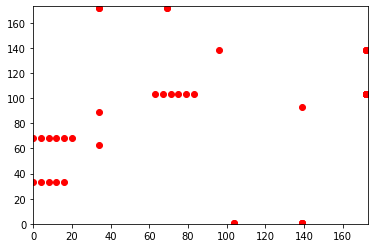

In [22]:
stoppedVehiclesPerStep.clear()
stoppedVehiclesCoordinatesX.clear()
stoppedVehiclesCoordinatesY.clear()

results = (SuperBlockModel(parameters)).run()

#Se genera el espacio para graficar
fig1, ax = plt.subplots()
index = 0
x = stoppedVehiclesCoordinatesX[index]
y = stoppedVehiclesCoordinatesY[index]

ln, = ax.plot(x, y, 'ro')
ax.set_xlim(0,173)
ax.set_ylim(0,173)

#Funcion para animar los vehiculos parados \n"
def animate(i):
    x = stoppedVehiclesCoordinatesX[index + i]
    y = stoppedVehiclesCoordinatesY[index + i]
    ln.set_data(x,y)

#Se genera la animacion 
ani = animation.FuncAnimation(fig1, animate, frames=150, interval=1000)

#Se despliega la animacion
IPython.display.HTML(ani.to_jshtml(fps=60))


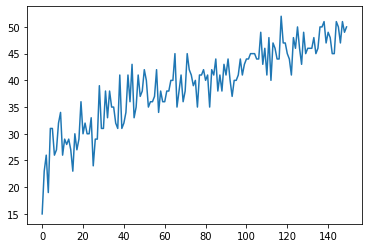

In [16]:
#Grafica del total de autos detenidos por cada step
plt.plot(stoppedVehiclesPerStep)
ax = fig.add_subplot(111)

plt.show()

# **Exportar resultados**

Esta opcion no es recomendable usarla durante el desarrollo ya que tiene que guardar 173**2 por el numero de steps. Solo usar cuando el server no se enciende

In [14]:
resultadosCars = pd.DataFrame(resultsCars)
resultadosBicicles = pd.DataFrame(resultsBicicles)
resultadosBuses = pd.DataFrame(resultsBuses)

#export to csv
#resultados.to_csv('resultados.csv') #exportar a csv

In [ ]:
import json

jsonCars = "\t\t["+resultadosCars.to_json(orient='records', indent=10)[1:-1]+"\t\t]"
jsonBicicles = "\t\t["+resultadosBicicles.to_json(orient='records', indent=10)[1:-1]+"\t\t]"
jsonBuses = "\t\t["+resultadosBuses.to_json(orient='records', indent=10)[1:-1]+"\t\t]"

jsonFinal = "{\n"+'\t"Cars"'+":\n"+jsonCars+",\n"+'\t"Bicicles"'+":\n"+jsonBicicles+",\n"+'\t"Buses"'+":\n"+jsonBuses+"\n}" #crea un json con los resultados

with open('./JSON/simulation.json', 'w', encoding='utf-8') as f:
    f.write(jsonFinal) #exportar a json